In [1]:
from requests import get
from json import dumps
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import datetime
import pyswarms as ps
from pyswarms.single.global_best import GlobalBestPSO
import scipy

In [2]:
def N_avg(a, N=7):
    # weekly avg into the past
    b = np.zeros(len(a)-N)
    for i in range(N,len(a),1):
        b[i-N] = np.mean(a[i-N:i])
    return b

def diff_axis(scale, ax1, ax2):
    _,l1 = ax1.get_ylim()
    _,l2 = ax2.get_ylim()
    d1 = np.array(ax1.lines[0].get_ydata())
    d2 = np.array(ax2.lines[0].get_ydata())
    return np.mean(np.abs(d1/scale-d2))
    
def match_axis(ax1, ax2):
    scale = scipy.optimize.minimize(diff_axis, 1, args=(ax1,ax2))
    _,l2 = ax2.get_ylim()
    ax1.set_ylim(0,l2*scale.x)  
    return scale.x

In [3]:
# download api data for England
req = "https://api.coronavirus.data.gov.uk/v2/data?areaType=nation&areaCode=E92000001&metric=newAdmissions&metric=newCasesBySpecimenDate&format=json"
response = get(req, timeout=10)
if response.status_code >= 400:
    raise RuntimeError(f'Request failed: { response.text }')
response = response.json()

df_england = pd.DataFrame(response['body'])
df_england['dateTime'] = pd.to_datetime(df_england['date'])
df_england.sort_values(by=['dateTime'], inplace=True)
df_england.dropna(inplace=True)

top_date = sorted(list(set(df_england.dateTime.to_list())))[-1].strftime("%Y-%m-%d")
print(top_date)

2021-12-15


In [4]:
# download api data for regions 
req = "https://api.coronavirus.data.gov.uk/v2/data?areaType=region&metric=newCasesBySpecimenDate&format=json"
response = get(req, timeout=10)
if response.status_code >= 400:
    raise RuntimeError(f'Request failed: { response.text }')
response = response.json()

df_regions_cases = pd.DataFrame(response['body'])
df_regions_cases['dateTime'] = pd.to_datetime(df_regions_cases['date'])
df_regions_cases.sort_values(by=['dateTime'], inplace=True)
df_regions_cases.dropna(inplace=True)

top_date_cases = sorted(list(set(df_regions_cases.dateTime.to_list())))[-1].strftime("%Y-%m-%d")
print(top_date_cases)

req = "https://api.coronavirus.data.gov.uk/v2/data?areaType=nhsRegion&metric=newAdmissions&format=json"
response = get(req, timeout=10)
if response.status_code >= 400:
    raise RuntimeError(f'Request failed: { response.text }')
response = response.json()

df_regions_nhs = pd.DataFrame(response['body'])
df_regions_nhs['dateTime'] = pd.to_datetime(df_regions_nhs['date'])
df_regions_nhs.sort_values(by=['dateTime'], inplace=True)
df_regions_nhs.dropna(inplace=True)

top_date_nhs = sorted(list(set(df_regions_nhs.dateTime.to_list())))[-1].strftime("%Y-%m-%d")
print(top_date_nhs)

top_date = min(top_date_cases, top_date_nhs)

2021-12-17
2021-12-15


In [5]:
# input defs
train_in_stream = []
train_out_stream = []
dates_train = []
test_in_stream = []
test_out_stream = []
dates_test = []

in_event = ""
out_event = ""
geographical_context = ""

train_start_date = "2020-11-15" 
train_end_date = "2021-03-01"
test_start_date = "2021-02-01"
test_end_date = top_date

In [12]:
# set data: England +ve tests -> hosp admissions
df = df_england
train_df = df[(df.dateTime >= train_start_date) & (df.dateTime <= train_end_date)]
test_df = df[(df.dateTime >= test_start_date) & (df.dateTime <= test_end_date)]

train_in_stream = np.array(train_df.newCasesBySpecimenDate.to_list(), dtype=float)
train_out_stream = np.array(train_df.newAdmissions.to_list(), dtype=float)
test_in_stream = np.array(test_df.newCasesBySpecimenDate.to_list(), dtype=float)
test_out_stream = np.array(test_df.newAdmissions.to_list(), dtype=float)
dates_train = sorted(list(set(train_df.dateTime.to_list())))
dates_test = sorted(list(set(test_df.dateTime.to_list())))

#train_in_stream = N_avg(train_in_stream)
#train_out_stream = N_avg(train_out_stream)
#test_in_stream = N_avg(test_in_stream)
#test_out_stream = N_avg(test_out_stream)

in_event = "+ve test"
out_event = "admitted"
geographical_context = "England"

In [83]:
# set data: Regional +ve tests -> hosp admissions
region = "London"
df_c = df_regions_cases[df_regions_cases.areaName==region]
df_n = df_regions_nhs[df_regions_nhs.areaName==region]

train_df_c = df_c[(df_c.dateTime >= train_start_date) & (df_c.dateTime <= train_end_date)]
train_df_n = df_n[(df_n.dateTime >= train_start_date) & (df_n.dateTime <= train_end_date)]
test_df_c = df_c[(df_c.dateTime >= test_start_date) & (df_c.dateTime <= test_end_date)]
test_df_n = df_n[(df_n.dateTime >= test_start_date) & (df_n.dateTime <= test_end_date)]

train_in_stream = np.array(train_df_c.newCasesBySpecimenDate.to_list(), dtype=float)
train_out_stream = np.array(train_df_n.newAdmissions.to_list(), dtype=float)
test_in_stream = np.array(test_df_c.newCasesBySpecimenDate.to_list(), dtype=float)
test_out_stream = np.array(test_df_n.newAdmissions.to_list(), dtype=float)
dates_train = sorted(list(set(train_df_c.dateTime.to_list())))
dates_test = sorted(list(set(test_df_c.dateTime.to_list())))

#train_in_stream = N_avg(train_in_stream)
#train_out_stream = N_avg(train_out_stream)
#test_in_stream = N_avg(test_in_stream)
#test_out_stream = N_avg(test_out_stream)

in_event = "+ve test"
out_event = "admitted"
geographical_context = region

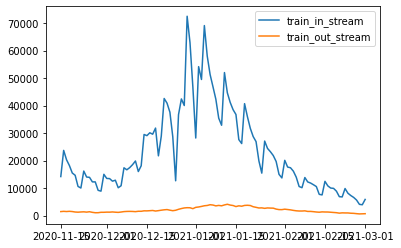

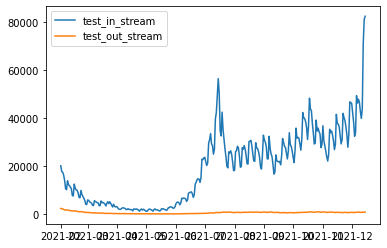

In [7]:
plt.clf()
plt.plot(dates_train, train_in_stream, label="train_in_stream")
plt.plot(dates_train, train_out_stream, label="train_out_stream")
plt.legend()
plt.show()
plt.clf()
plt.plot(dates_test, test_in_stream, label="test_in_stream")
plt.plot(dates_test, test_out_stream, label="test_out_stream")
plt.legend()
plt.show()

In [8]:
def _f(x, in_stream, out_stream):
    # model out_stream as a convolution of in_stream with x
    target_out_stream = out_stream[len(x)-1:]
    pred_out_stream = np.convolve(in_stream, x, mode="valid")
    return target_out_stream, pred_out_stream

def f(xs, in_stream=train_in_stream, out_stream=train_out_stream):
    ret = np.zeros(np.shape(xs)[0])
    for i in range(len(ret)):
        x = xs[i,:]
        target_out_stream, pred_out_stream = _f(x, in_stream, out_stream)
        ret[i] = np.sum(np.abs(pred_out_stream - target_out_stream)) / len(pred_out_stream)
    return ret        

In [16]:
n_dim = 40
n_particles = 1000

x_max = 0.03*np.ones(n_dim)
x_min = 0*np.ones(n_dim)
options = {'c1': 0.4, 'c2': 0.2, 'w': 0.5}
bounds = (x_min, x_max)
init_pos = np.array([np.zeros(n_dim) for i in range(n_particles)])

_minimizers = []

for i in range(20):
    optimizer = GlobalBestPSO(n_particles=n_particles, dimensions=n_dim, options=options, bounds=bounds, init_pos=init_pos)
    cost, pos = optimizer.optimize(f, 1000, verbose=True, n_processes=10)
    _minimizers.append(pos)
minimizers = np.array(_minimizers)

2021-12-19 08:39:56,039 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.4, 'c2': 0.2, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=84.8
2021-12-19 08:40:01,473 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 84.7833305453933, best pos: [ 6.19460947e-03  3.61402611e-03  7.67750733e-03  4.62555245e-03
  1.23546641e-03  8.08622599e-03  6.91670290e-03  3.92113823e-03
  6.65477017e-03  3.40815785e-03  1.10316377e-03  6.31339174e-03
  1.09730229e-03  4.04434600e-03  2.23078914e-03  5.72623582e-04
  6.97385466e-03  8.28214699e-04 -7.85546382e-04 -3.79280486e-04
  7.11182493e-03  3.09464190e-03  1.57908923e-03 -8.22625295e-04
 -1.64216135e-03 -1.46990648e-03 -1.21878292e-03 -1.11298675e-03
  9.99919753e-05 -6.02504193e-04  7.14370344e-04  1.11631413e-03
 -6.90128402e-04  9.03962645e-04  2.52012215e-03  1.15706313e-03
 -1.45994910e-03  7.22151972e-04  5.56151730e-04 -9.66926183e-04]
2021-12-19 08:40:01,479 - p

2021-12-19 08:40:45,989 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.4, 'c2': 0.2, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=101 
2021-12-19 08:40:51,413 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 100.89517812927525, best pos: [ 6.70596528e-03  4.71396580e-03  5.62138400e-03  4.56034671e-03
  2.55559435e-03  5.69683809e-03  5.83643823e-03  8.31316858e-03
  5.21612028e-03  1.28836149e-03  2.60081598e-03  2.56814687e-03
  7.25709863e-03  3.66988094e-03  3.26838162e-03  1.36591298e-03
  1.56470812e-03  2.57672085e-04  1.11580328e-03  2.28854723e-04
  2.20499399e-03  8.93800553e-04  5.08349283e-06  3.64582936e-03
 -1.56894918e-03  4.19347981e-04 -3.41365410e-04  4.51051915e-04
  2.74925530e-03  1.31491581e-03 -1.35483872e-03  1.01622116e-03
  9.03280307e-04 -7.80536292e-04 -1.43933176e-04  7.75880362e-04
 -1.47459274e-03  2.19999308e-04  1.00117073e-03 -7.95163218e-04]
2021-12-19 08:40:51,447 -

2021-12-19 08:41:35,495 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.4, 'c2': 0.2, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=96.1
2021-12-19 08:41:40,875 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 96.08476566397522, best pos: [ 5.59422916e-03  3.95198153e-03  6.95043257e-03  2.09966697e-03
  4.43606526e-03  2.66509055e-03  9.73100387e-03  7.23955959e-03
  2.61461659e-03  5.76189330e-03  2.12052610e-03  4.35987384e-03
  3.52736147e-03  3.33815813e-03  4.76233164e-03  1.72479395e-03
  2.34116630e-03  1.77110650e-03 -6.30357477e-04  5.47380927e-04
  3.23668714e-03 -2.13146708e-04  5.08783004e-04  1.82818246e-03
 -1.69102012e-03  3.83812017e-04  4.12513815e-04  6.29762587e-05
  1.01879224e-03  6.05451321e-04 -5.35763750e-04  1.41559630e-03
 -1.45306870e-03 -7.44798024e-04  2.63815098e-03  9.29856256e-04
 -3.42978360e-04  4.65932279e-06  2.16604942e-04 -4.45756981e-05]
2021-12-19 08:41:40,882 - 

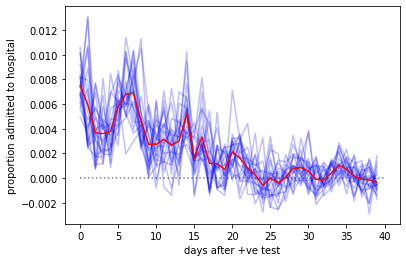

<Figure size 432x288 with 0 Axes>

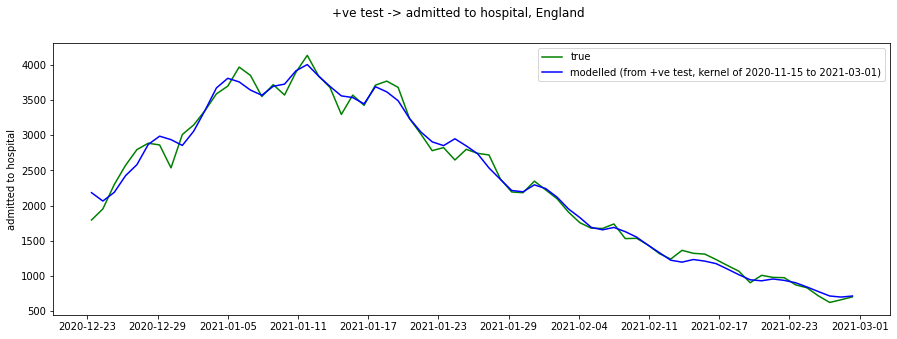

<Figure size 432x288 with 0 Axes>

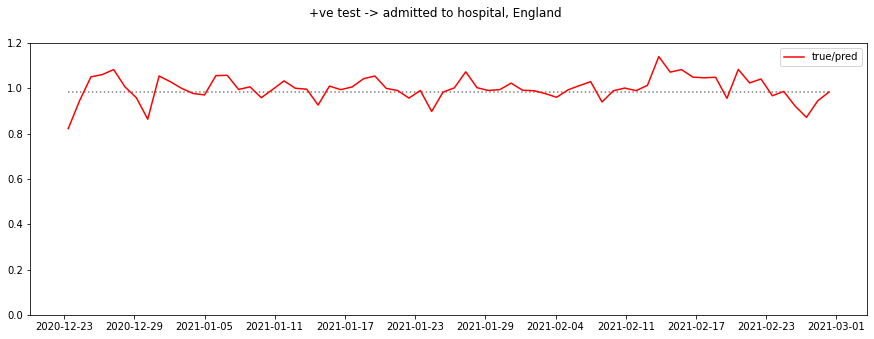

<Figure size 432x288 with 0 Axes>

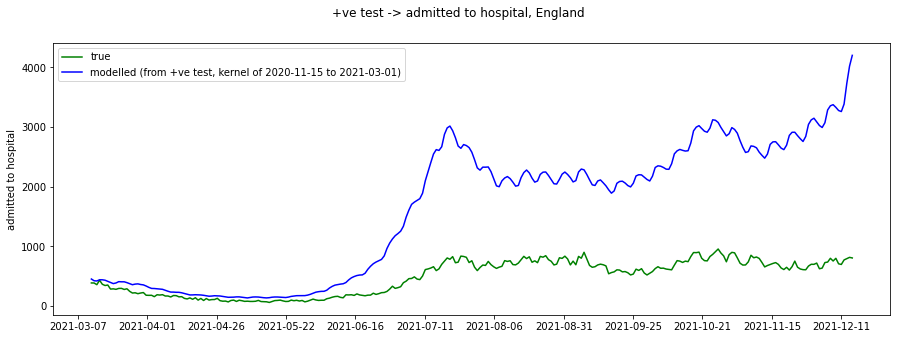

<Figure size 432x288 with 0 Axes>

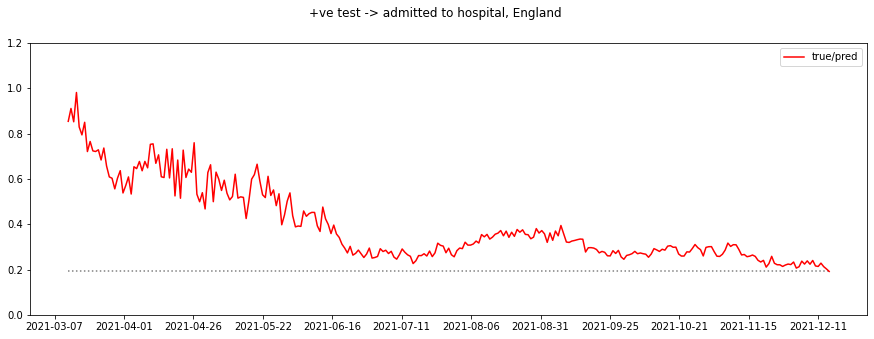

In [30]:
# show kernel
plt.clf()
z = list(range(len(pos)))
for y in minimizers:
    plt.plot(z, y, color="blue", alpha=0.25)
avg_minimizer = []
for i in range(len(minimizers[0])):
    avg_minimizer.append(np.mean(minimizers[:,i]))
avg_minimizer = np.array(avg_minimizer)
plt.plot(z, avg_minimizer, color="red", alpha=1)
plt.xlabel("days after %s" % in_event)
plt.ylabel("proportion %s" % out_event)
plt.hlines(0, 0,len(z), ls="dotted", alpha=0.5, color="black")
plt.savefig("%s__%s__kernel__%s.png" % (in_event, out_event, geographical_context), bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

#print("mass: %.2f" % np.sum(avg_minimizer))

# show fit to training & testing
def make_graph(dates, kernel, in_stream, out_stream, test_train):
    plt.clf()
    assert(len(in_stream)==len(out_stream))
    assert(len(kernel)<=len(in_stream))
    true, pred = _f(avg_minimizer, in_stream, out_stream) 
    x = dates[-len(true):]
    fig, ax1 = plt.subplots(1,1, figsize=(15,5))
    ax1.plot(x, true, color="green", label="true")
    ax1.plot(x, pred, color="blue", label="modelled (from %s, kernel of %s to %s)" % (in_event, train_start_date, train_end_date))
    ax1.set_ylabel("%s" % out_event)
    ax1.legend()
    ax = plt.gca()
    n_marks = 11
    ax.xaxis.set_major_locator(ticker.MultipleLocator(len(x)/n_marks))
    fig.suptitle("%s -> %s, %s" % (in_event, out_event, geographical_context))
    plt.savefig("%s__%s__%s__%s.png" % (in_event, out_event, test_train, geographical_context), bbox_inches='tight', facecolor='white', transparent=False)
    plt.show()
    
    plt.clf()
    fig, ax1 = plt.subplots(1,1, figsize=(15,5))
    plt.plot(x, true/pred, color="red", label="true/pred")
    plt.hlines((true/pred)[-1], x[0], x[-1], ls="dotted", alpha=0.5, color="black")
    plt.ylim(0,1.2)
    plt.legend()
    ax = plt.gca()
    ax.xaxis.set_major_locator(ticker.MultipleLocator(len(x)/n_marks))
    fig.suptitle("%s -> %s, %s" % (in_event, out_event, geographical_context))
    plt.savefig("%s__%s__%s__%s__ratio.png" % (in_event, out_event, test_train, geographical_context), bbox_inches='tight', facecolor='white', transparent=False)
    plt.show()
    
make_graph(dates_train, avg_minimizer, train_in_stream, train_out_stream, "train") 
make_graph(dates_test, avg_minimizer, test_in_stream, test_out_stream, "test") 




In [31]:
print(avg_minimizer)

[ 7.50272199e-03  5.96672998e-03  3.66366242e-03  3.61230930e-03
  3.79097672e-03  5.81660713e-03  6.79926515e-03  6.89017811e-03
  4.65287608e-03  2.74895128e-03  2.74575124e-03  3.16898102e-03
  2.67619518e-03  3.00616100e-03  5.20405770e-03  1.60391627e-03
  3.34443664e-03  1.19709188e-03  1.18538345e-03  6.89388277e-04
  2.13167673e-03  1.61687426e-03  8.22663649e-04  2.70671669e-04
 -5.90131375e-04  1.68198251e-06 -3.77975947e-04  5.96172193e-05
  7.94503510e-04  8.65474143e-04  5.62418499e-04 -9.22534712e-05
 -1.67662134e-04  4.18981740e-04  1.04044168e-03  7.38226659e-04
  1.58947600e-04 -9.49362873e-05 -1.41845839e-04 -3.53844388e-04]
